In [381]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization (Static)
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization (Interactive)
import plotly.express as px

# Machine Learning & Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Import Data 

In [382]:
final_dataset=pd.read_csv("/Users/leoss/Desktop/Capstone/Code/comprehensive_dataset.csv")
"""clmns_cluster=['Economic Complexity', 
       'Gross domestic product (GDP), Per capita, purchasing power parity (PPP) international dollar, ICP benchmarks 2017-2021',
       'Mineral rents (% of GDP)', 'Natural gas rents (% of GDP)',
       'Oil rents (% of GDP)', 
       'Revenue, General government, Percent of GDP','Rents']"""

"clmns_cluster=['Economic Complexity', \n       'Gross domestic product (GDP), Per capita, purchasing power parity (PPP) international dollar, ICP benchmarks 2017-2021',\n       'Mineral rents (% of GDP)', 'Natural gas rents (% of GDP)',\n       'Oil rents (% of GDP)', \n       'Revenue, General government, Percent of GDP','Rents']"

## Make sure there is a country name - country code mapping 

In [383]:
#Manually fixing the names:
mapping={"AFG":'Afghanistan',
         'ARM':'Armenia',
         'AZE':'Azerbaijan',
         'BHR':'Bahrain',
         'BLR':'Belarus',
         'CHN':'China',
         'CIV':"Cote d'Ivoire",
         'COD':'Congo Dem. Rep.',
         'COG':'Congo',
         'CZE':"Czechia",
         'EGY':"Egypt",
         'EST':'Estonia',
         'ETH':'Ethiopia',
         'GNQ':'Equatorial Guinea',
         'HKG':'Hong Kong',
         'HRV':'Croatia',
         'IRN':'Iran',
         'KAZ':'Kazakhstan',
         'LAO':'Laos',
         "LTU":'Lithuania',
         'LVA':'Latvia',
         'MDA':'Moldova',
         'KOR':'South Korea',
         'KAZ':'Kazakhstan',
         'MDG':'Madagascar',
         'MKD':'North Macedonia',
         'MOZ':'Mozambique',
         'MRT':'Mauritania',
         'NLD':'Netherlands',
         'POL':'Poland',
         'RUS':'Russia',
         'SRB':'Serbia',
         'SVN':'Slovenia',
         'SWZ':'Eswatini',
         'TJK':'Tajikistan',
         'TUR':'Turkey',
         'TWN':'Taiwan',
         'TZA':"Tanzania",
         'UZB':'Uzbekistan',
         'VEN':'Venezuela',
         "VNM":"Vietnam",
         'YEM':'Yemen'
         }

# Assign clear mapping of code to name
valid_names = final_dataset.dropna(subset=['Country Name'])
code_to_name_map_df = valid_names.drop_duplicates(subset=['Country Code'])
clean_map_dict = pd.Series(
    code_to_name_map_df['Country Name'].values, 
    index=code_to_name_map_df['Country Code']
).to_dict()
clean_map_dict.update(mapping)

## Column selection

In [384]:
#Filter and Aggregate Mean 
df_period = final_dataset.query("2014 <= Year <= 2021").copy()
df_grouped = df_period.groupby(['Country Name', 'Series Name'])['Value'].mean().reset_index()
data_wide = df_grouped.pivot(index='Country Name', columns='Series Name', values='Value')
data_wide_imputed=data_wide.dropna()

ratio_gdp_pop = data_wide_imputed['GDP (current US$)'] / data_wide_imputed["Population, total"]
data_wide_imputed['Mineral rents per capita'] = data_wide_imputed['Mineral rents (% of GDP)'] * ratio_gdp_pop
data_wide_imputed['Oil rents per capita']= data_wide_imputed['Oil rents (% of GDP)'] * ratio_gdp_pop
data_wide_imputed['Natural Gas rents per capita']   = data_wide_imputed['Natural gas rents (% of GDP)'] * ratio_gdp_pop
data_wide_imputed['Natural resource rents per capita']   = data_wide_imputed['Total natural resources rents (% of GDP)'] * ratio_gdp_pop

data_wide_imputed = data_wide_imputed.rename(columns={
    'Gross domestic product (GDP), Per capita, purchasing power parity (PPP) international dollar, ICP benchmarks 2017-2021': 'GDP per capita PPP',
    "Revenue, General government, Percent of GDP":"Government Revenue (% of GDP)"
})

#Select Columns for Clustering
clmns_cluster = [
    'Economic Complexity', 
    'GDP per capita PPP',
    'Mineral rents (% of GDP)', 
    'Natural gas rents (% of GDP)',
    'Oil rents (% of GDP)', 
    #'Total natural resources rents (% of GDP)',
    'Government Revenue (% of GDP)',
    #'Mineral',
    'Oil rents per capita',
    'Natural resource rents per capita',
    'Natural Gas rents per capita'
]
# We check intersection to ensure all columns exist before subsetting
available_cols = [c for c in clmns_cluster if c in data_wide_imputed.columns]
datset_wide_cluster = data_wide_imputed[available_cols].copy()

# Ensure no remaining NaNs (in case a column was fully empty and mean imputation failed)
data_ready_for_scaling = datset_wide_cluster.dropna()

"""print(f"Data ready for scaling. Shape: {data_ready_for_scaling.shape}")
print(data_ready_for_scaling.head())"""
scaler_filtered = StandardScaler()
countries_scaled_filtered_df = pd.DataFrame(
scaler_filtered.fit_transform(datset_wide_cluster),
columns=clmns_cluster,
index=datset_wide_cluster.index
)

/var/folders/lk/thldsylx4nx779cggs7gnk900000gn/T/ipykernel_13623/259028659.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lk/thldsylx4nx779cggs7gnk900000gn/T/ipykernel_13623/259028659.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lk/thldsylx4nx779cggs7gnk900000gn/T/ipykernel_13623/259028659.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

# Clustering 

## K-elbow

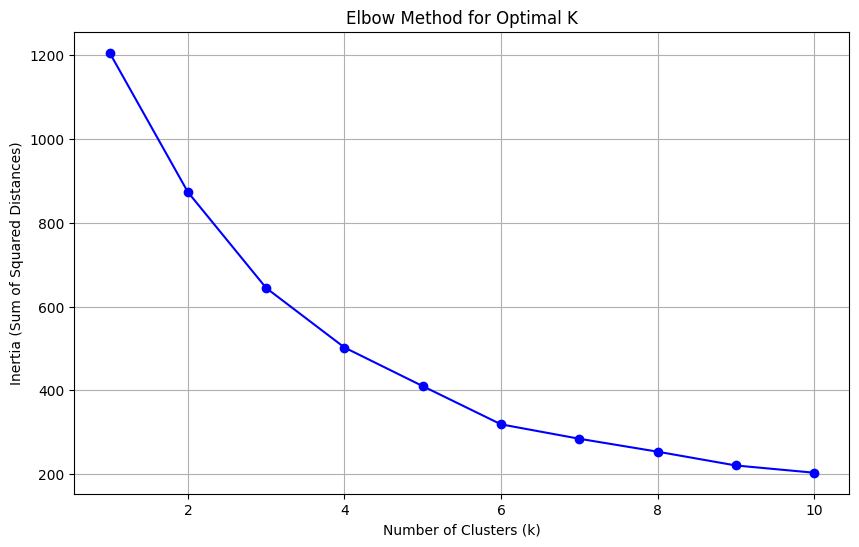

In [385]:
#Do the k-elbow plot
inertia = []
K_range = range(1, 11) 
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=20) 
    kmeans.fit(countries_scaled_filtered_df)
    inertia.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-') 
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

## Clustering itself 

In [386]:
data_for_clustering = countries_scaled_filtered_df.copy()

# Fit the k=6 model
k_country_6_filtered = KMeans(n_clusters=6, random_state=0, n_init=100)
k_country_6_filtered.fit(data_for_clustering) 
countries_scaled_filtered_df['cluster_6'] = k_country_6_filtered.labels_
data_for_pca = data_for_clustering 
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_for_pca)

#Create a new DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(
    data=pca_components, 
    columns=['PC1', 'PC2'], 
    index=data_for_pca.index
)

# Add the labels from your main df
pca_df['cluster_6'] = countries_scaled_filtered_df['cluster_6']
pca_df['Country Code'] = pca_df.index 
pca_df['Country Name'] = pca_df.index.map(clean_map_dict)
countries_to_label = ['USA', 'CHN', 'RUS', 'AGO'] 
label_data = pca_df[pca_df.index.isin(countries_to_label)]

#k_country_8_filtered = KMeans(n_clusters=8, random_state=0, n_init=100)
#k_country_8_filtered.fit(data_for_clustering)
#countries_scaled_filtered_df['cluster_8'] = k_country_8_filtered.labels_
#pca_df['cluster_8'] = countries_scaled_filtered_df['cluster_8']

## PCA loadings and cluster summary

PCA Loadings (Influence of each variable on the axes):
                                        PC1       PC2
Economic Complexity                0.090936  0.603303
GDP per capita PPP                 0.309235  0.447705
Mineral rents (% of GDP)          -0.118045 -0.278947
Natural gas rents (% of GDP)       0.317294 -0.252746
Oil rents (% of GDP)               0.335462 -0.233562
Government Revenue (% of GDP)      0.195263  0.448449
Oil rents per capita               0.471319 -0.112060
Natural resource rents per capita  0.487960 -0.121483
Natural Gas rents per capita       0.413020 -0.104503


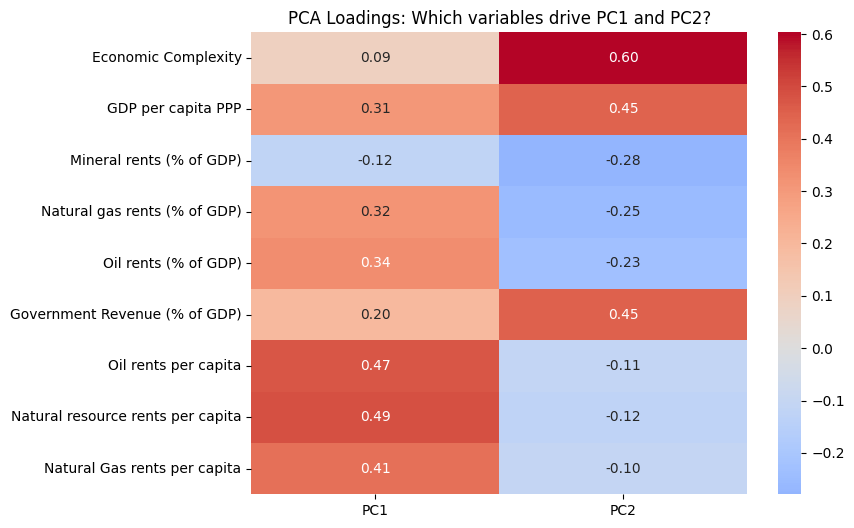

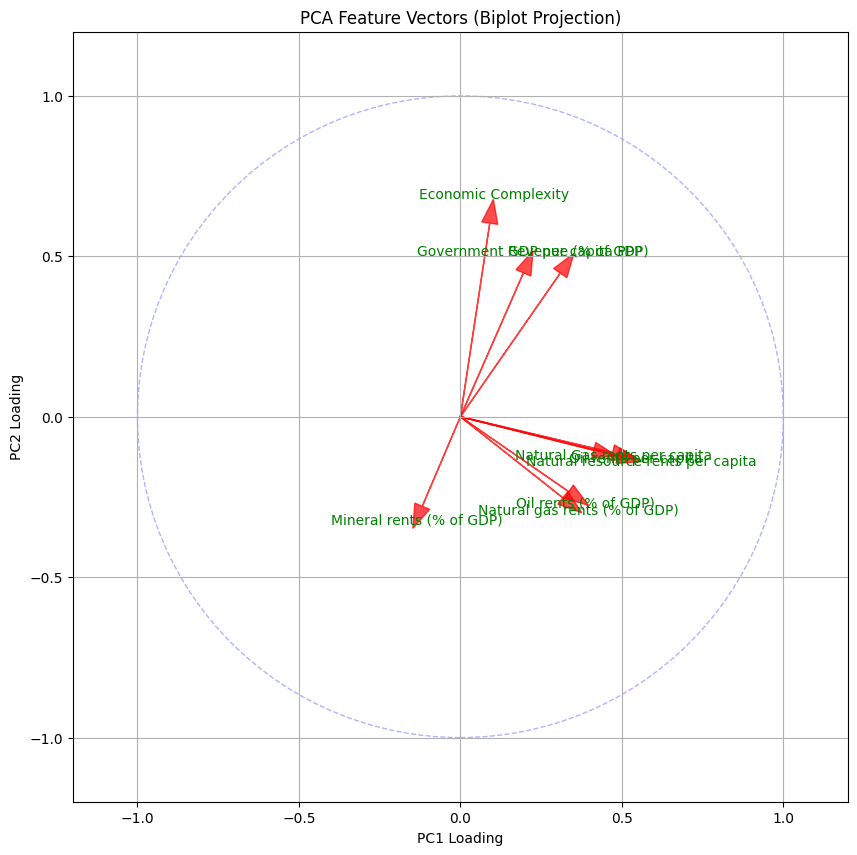

In [387]:
#Extract Loadings 
loadings = pd.DataFrame(
    pca.components_.T,  
    columns=['PC1', 'PC2'],
    index=data_for_pca.columns  
)
print("PCA Loadings (Influence of each variable on the axes):")
print(loadings)

#Visualize Loadings with a Heatmap 
plt.figure(figsize=(8, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('PCA Loadings: Which variables drive PC1 and PC2?')
plt.show()

#Visualize Loadings as Vectors (Biplot style) 

plt.figure(figsize=(10, 10))
for i, feature in enumerate(data_for_pca.columns):
    plt.arrow(0, 0, 
              loadings.iloc[i, 0],  # x component (PC1)
              loadings.iloc[i, 1],  # y component (PC2)
              color='r', alpha=0.7, head_width=0.05)
    # Add text labels for features (offset slightly for readability)
    plt.text(loadings.iloc[i, 0]*1.15, 
             loadings.iloc[i, 1]*1.15, 
             feature, 
             color='g', ha='center', va='center', fontsize=10)

#Draw the circle (optional, helps see scale)
circle = plt.Circle((0,0), 1, color='b', fill=False, linestyle='--', alpha=0.3)
plt.gca().add_artist(circle)
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.xlabel('PC1 Loading')
plt.ylabel('PC2 Loading')
plt.grid()
plt.title('PCA Feature Vectors (Biplot Projection)')
plt.show()

In [388]:
#Print cluster (k=8)
"""print("\nCluster sizes (k=8):")
print(countries_scaled_filtered_df.groupby('cluster_8').size())
for cluster, item in countries_scaled_filtered_df.groupby('cluster_8'):
    clustered_countries = item.index.tolist()
    print(f"\nCluster {cluster} (k=8):")
    print(*clustered_countries, sep=', ')"""

#Print cluster (k=6)
print("\nCluster sizes (k=6):")
print(countries_scaled_filtered_df.groupby('cluster_6').size())
for cluster, item in countries_scaled_filtered_df.groupby('cluster_6'):
    clustered_countries = item.index.tolist()
    print(f"\nCluster {cluster} (k=6):")
    print(*clustered_countries, sep=', ')


Cluster sizes (k=6):
cluster_6
0    42
1    62
2     4
3    14
4     1
5    11
dtype: int64

Cluster 0 (k=6):
Austria, Belarus, Belgium, Bosnia and Herzegovina, Bulgaria, Canada, China, Croatia, Cyprus, Czechia, Denmark, Estonia, Finland, France, Germany, Greece, Hong Kong, Hungary, Ireland, Israel, Italy, Japan, Latvia, Lithuania, Malaysia, Netherlands, New Zealand, Poland, Portugal, Romania, Serbia, Singapore, Slovak Republic, Slovenia, South Korea, Spain, Sweden, Switzerland, Turkey, Ukraine, United Kingdom, United States

Cluster 1 (k=6):
Afghanistan, Argentina, Armenia, Bangladesh, Benin, Bolivia, Botswana, Brazil, Cambodia, Cameroon, Chad, Colombia, Costa Rica, Cote d'Ivoire, Dominican Republic, Ecuador, Egypt, El Salvador, Eswatini, Ethiopia, Gabon, Georgia, Ghana, Guatemala, Haiti, Honduras, India, Indonesia, Jamaica, Jordan, Kenya, Laos, Lebanon, Madagascar, Mauritius, Mexico, Moldova, Morocco, Mozambique, Namibia, Nepal, Nicaragua, Niger, North Macedonia, Pakistan, Panama, P

## Cluster Map (PCA) and feature importance

In [389]:
#Drop stale columns if they exist
stale_cols = ['cluster_6', 'cluster_8', 'Country Code', 'Country Name'] # Removed duplicate 'cluster_6'
pca_df = pca_df.drop(columns=[c for c in stale_cols if c in pca_df.columns])

#Re-add the Cluster Labels
#pca_df['cluster_8'] = countries_scaled_filtered_df['cluster_8']
pca_df['cluster_6'] = countries_scaled_filtered_df['cluster_6']
pca_df['Country Name'] = pca_df.index
name_to_code_reference = final_dataset[['Country Name', 'Country Code']].drop_duplicates().set_index('Country Name')['Country Code']
pca_df['Country Code'] = pca_df['Country Name'].map(name_to_code_reference)
print(f"Missing Codes: {pca_df['Country Code'].isna().sum()}")

"""# Create the interactive k=8 plot
fig = px.scatter(
    pca_df, 
    x='PC1', 
    y='PC2', 
    color='cluster_8',
    hover_name='Country Code',
    hover_data={               
        'Country Name': True, 
        'cluster_8': True,
        'PC1': ':.2f',
        'PC2': ':.2f'
    },
    title='Interactive PCA Plot of K-Means Clusters (k=8) - Hover by Country Code'
)
fig.update_traces(marker=dict(size=10, opacity=0.8))
fig.show()"""

#Interactive plots for k=6
fig = px.scatter(
    pca_df, 
    x='PC1', 
    y='PC2', 
    color='cluster_6',
    hover_name='Country Code', 
    hover_data={
        'Country Name': True,
        'cluster_6': True, 
        'PC1': ':.2f',
        'PC2': ':.2f'
    },
    title='Interactive PCA Plot of K-Means Clusters (k=6) - Hover by Country Code'
)
fig.update_traces(marker=dict(size=10, opacity=0.8))
fig.show()

Missing Codes: 0


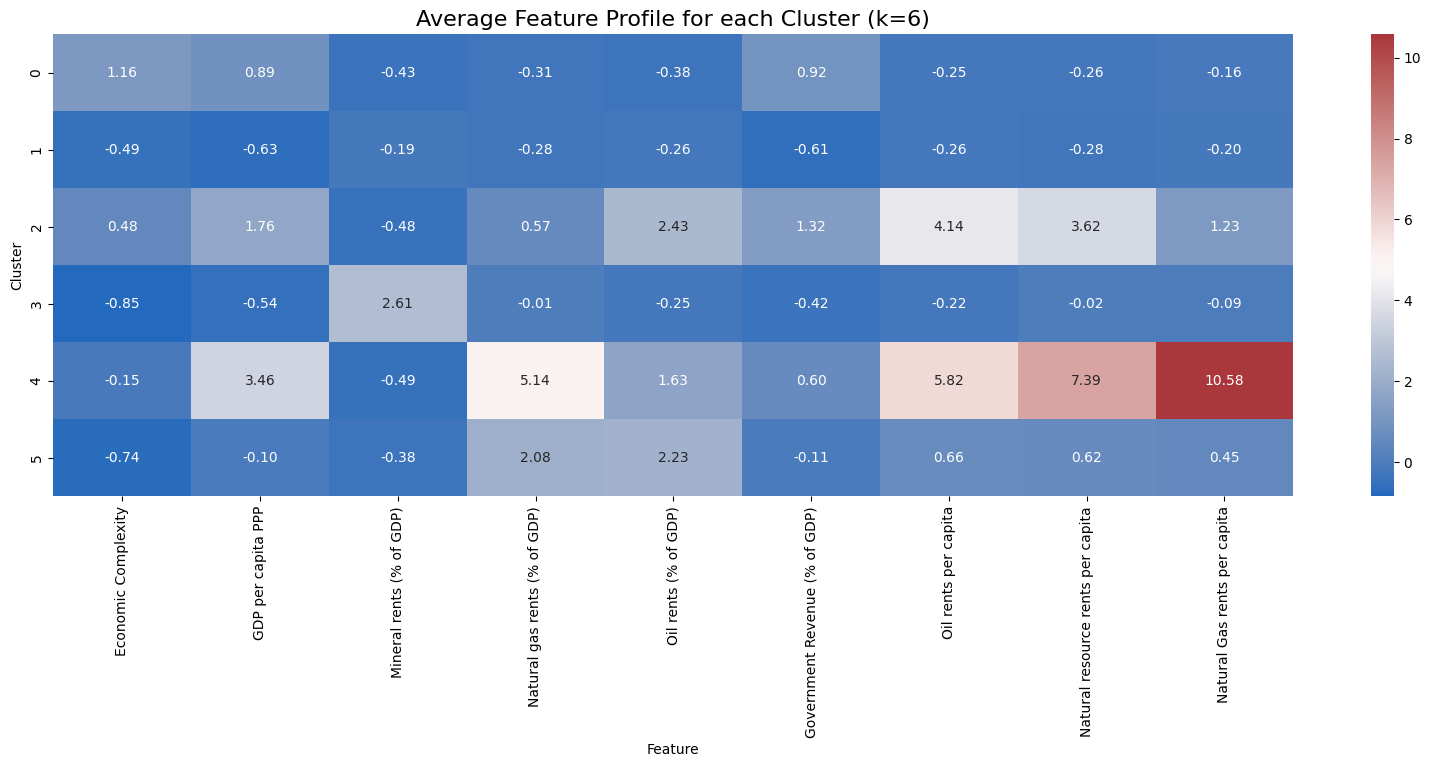

In [390]:
#Get Centroids (Average Profiles)
"""
centroids_k8 = k_country_8_filtered.cluster_centers_
centroid_df_k8 = pd.DataFrame(
    centroids_k8, 
    columns=data_for_pca.columns 
)
#Plot Heatmaps 
plt.figure(figsize=(20, 4))
sns.heatmap(
    centroid_df_k8, 
    annot=True,     
    cmap='vlag',    
    fmt='.2f'       
)
plt.title('Average Feature Profile for each Cluster (k=8)', fontsize=16)
plt.ylabel('Cluster')
plt.xlabel('Feature')
plt.show()"""

centroids_k6 = k_country_6_filtered.cluster_centers_
centroid_df_k6 = pd.DataFrame(
    centroids_k6, 
    columns=data_for_pca.columns 
)
plt.figure(figsize=(20, 6)) 
sns.heatmap(
    centroid_df_k6, 
    annot=True, 
    cmap='vlag', 
    fmt='.2f'
)
plt.title('Average Feature Profile for each Cluster (k=6)', fontsize=16)
plt.ylabel('Cluster')
plt.xlabel('Feature')
plt.show()

## Cluster map

In [391]:
#Prepare DataFrame for Categorical Plotting
map_df = pca_df.copy()
map_df['cluster_6'] = map_df['cluster_6'].astype(str)

# --- 3. Create the k=6 Choropleth Map ---
fig_map_6 = px.choropleth(
    map_df,
    locations="Country Code",
    color="cluster_6",
    hover_name="Country Name",
    hover_data=["Country Code", "cluster_6"],
    title="Clustering by Economic Indicators and resource use (k=6, 2015-2021)",
    color_discrete_sequence=px.colors.qualitative.Plotly
)

fig_map_6.update_geos(
    projection_type="natural earth",
    showcountries=True,
    showcoastlines=True
)
fig_map_6.show()


"""#Create the k=4 Choropleth Map
map_df['cluster_8'] = map_df['cluster_8'].astype(str)
fig_map_8 = px.choropleth(
    map_df,
    locations="Country Code",   
    color="cluster_8",          
    hover_name="Country Name",  
    hover_data=["Country Code", "cluster_8"], 
    title="Clustering by Economic Indicators and resource use (k=8, 2015-2024)",
    color_discrete_sequence=px.colors.qualitative.Plotly 
)

fig_map_8.update_geos(
    projection_type="natural earth",
    showcountries=True,
    showcoastlines=True
)
fig_map_8.show()"""


'#Create the k=4 Choropleth Map\nmap_df[\'cluster_8\'] = map_df[\'cluster_8\'].astype(str)\nfig_map_8 = px.choropleth(\n    map_df,\n    locations="Country Code",   \n    color="cluster_8",          \n    hover_name="Country Name",  \n    hover_data=["Country Code", "cluster_8"], \n    title="Clustering by Economic Indicators and resource use (k=8, 2015-2024)",\n    color_discrete_sequence=px.colors.qualitative.Plotly \n)\n\nfig_map_8.update_geos(\n    projection_type="natural earth",\n    showcountries=True,\n    showcoastlines=True\n)\nfig_map_8.show()'

# Cluster variations across time 

## Pre-processing 

In [392]:
#Only use years from 2015 to 2021
final_dataset['Year'] = final_dataset['Year'].astype(int)
df_start_end = final_dataset[final_dataset['Year'].isin([2015, 2021])].copy()
print(df_start_end["Year"].value_counts())
df_start_end['Year'] = df_start_end['Year'].astype(int) 

#Pivot the data to get 2015 and 2021 side-by-side

data_pivot = df_start_end.pivot_table(
    index=['Country Code', 'Series Name'], 
    columns='Year', 
    values='Value'
)
# Calculate absolute change
df_change = (data_pivot[2021] - data_pivot[2015]).reset_index()
df_change.columns = ['Country Code', 'Series Name', 'Net_Change'] 
data_wide_change = df_change.pivot(
    index='Country Code', 
    columns='Series Name', 
    values='Net_Change'
)

#Clean up data
data_wide_imputed_var = data_wide_change.dropna()
print(f"Data shape after calculating change and dropping NaNs: {data_wide_imputed_var.shape}")

#Re-add the Calculated Per Capita Features 

data_wide_imputed_var = data_wide_imputed_var.rename(columns={
    'Gross domestic product (GDP), Per capita, purchasing power parity (PPP) international dollar, ICP benchmarks 2017-2021': 'GDP per capita PPP',
    "Revenue, General government, Percent of GDP":"Government Revenue (% of GDP)"
})
ratio_gdp_pop_change = data_wide_imputed_var['GDP (current US$)'] / data_wide_imputed_var["Population, total"]
data_wide_imputed_var['Mineral change per capita'] = data_wide_imputed_var['Mineral rents (% of GDP)'] * ratio_gdp_pop_change
data_wide_imputed_var['Oil rents change per capita']= data_wide_imputed_var['Oil rents (% of GDP)'] * ratio_gdp_pop_change
data_wide_imputed_var['Natural Gas rents change per capita']   = data_wide_imputed_var['Natural gas rents (% of GDP)'] * ratio_gdp_pop_change
data_wide_imputed_var['Natural resource rents change per capita']   = data_wide_imputed_var['Total natural resources rents (% of GDP)'] * ratio_gdp_pop_change
final_cluster_cols = [
    'Economic Complexity', 
    'GDP per capita PPP',
    'Government Revenue (% of GDP)',
    'Mineral rents (% of GDP)',
    'Natural gas rents (% of GDP)', 
    'Oil rents (% of GDP)',
    'Total natural resources rents (% of GDP)',
    'Mineral change per capita',
    'Oil rents change per capita',
    'Natural resource rents change per capita',
    'Natural Gas rents change per capita'
]

#We check intersection to ensure all columns exist before subsetting
available_cols = [c for c in final_cluster_cols if c in data_wide_imputed_var.columns]
datset_wide_cluster = data_wide_imputed_var[available_cols].copy()
data_ready_for_scaling = datset_wide_cluster.dropna()
print(f"Data ready for scaling. Shape: {data_ready_for_scaling.shape}")

#Scale the data
scaler_filtered = StandardScaler()
countries_scaled_filtered_df = pd.DataFrame(
    scaler_filtered.fit_transform(data_ready_for_scaling),
    columns=available_cols, 
    index=data_ready_for_scaling.index
)

Year
2015    1420
2021    1420
Name: count, dtype: int64
Data shape after calculating change and dropping NaNs: (134, 10)
Data ready for scaling. Shape: (134, 11)


## Clustering Variation

PCA Loadings (Influence of each variable on the axes):
                                               PC1       PC2
Economic Complexity                      -0.004004 -0.026081
GDP per capita PPP                        0.068790 -0.162377
Government Revenue (% of GDP)             0.054063  0.429544
Mineral rents (% of GDP)                  0.018125  0.265044
Natural gas rents (% of GDP)              0.147670  0.235413
Oil rents (% of GDP)                      0.071201  0.536174
Total natural resources rents (% of GDP)  0.098958  0.593091
Mineral change per capita                 0.473562 -0.060673
Oil rents change per capita               0.491971 -0.091843
Natural resource rents change per capita  0.495604 -0.078738
Natural Gas rents change per capita       0.493368 -0.072263


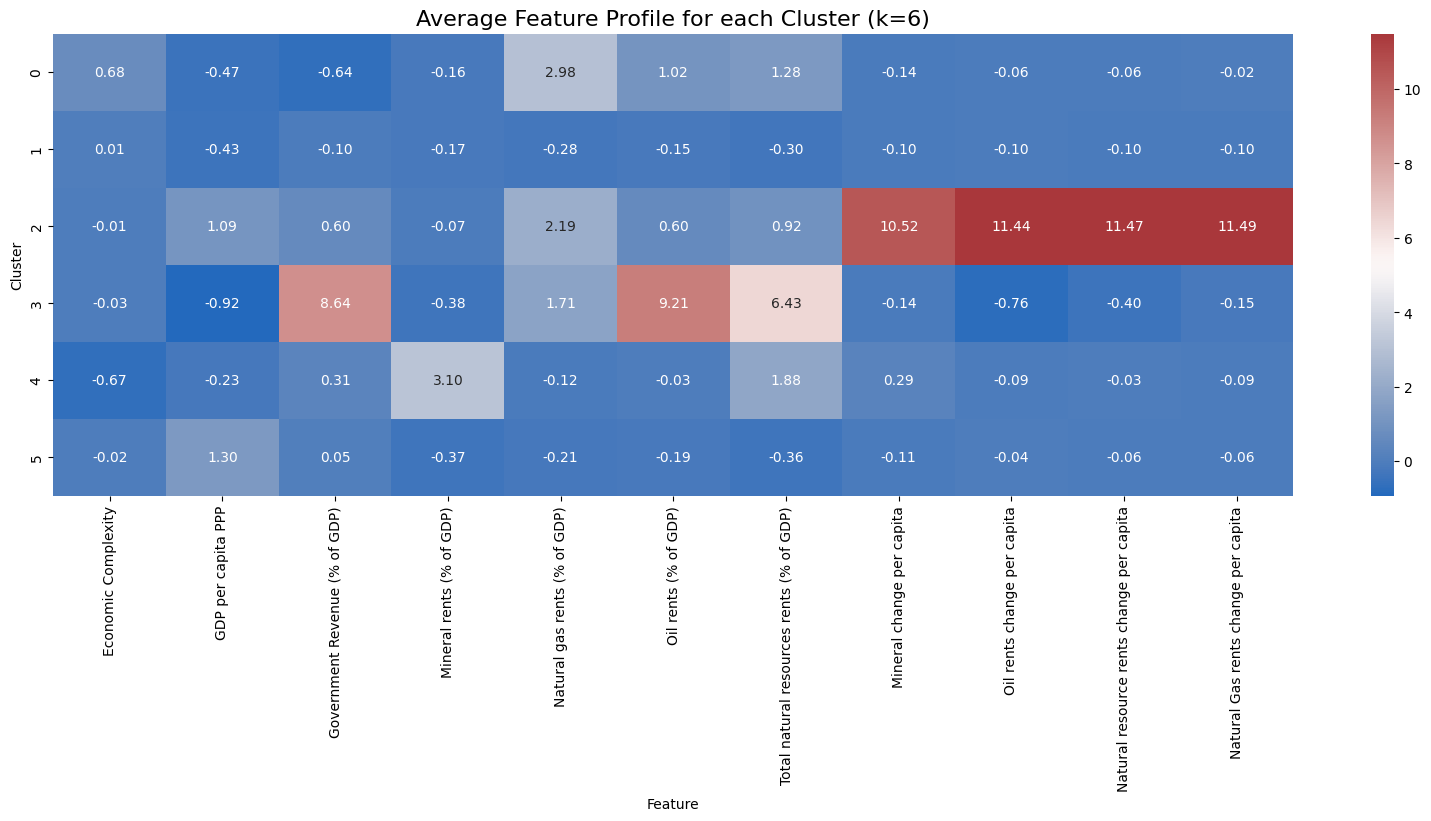

In [393]:
data_for_clustering_var = countries_scaled_filtered_df.copy()
#Fit the k=6 model
k_country_6_filtered = KMeans(n_clusters=6, random_state=0, n_init=100)
k_country_6_filtered.fit(data_for_clustering_var) 
countries_scaled_filtered_df['cluster_6'] = k_country_6_filtered.labels_
#PCA and Visualization (as before)
data_for_pca = data_for_clustering_var
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_for_pca)
pca_df = pd.DataFrame(
    data=pca_components, 
    columns=['PC1', 'PC2'], 
    index=data_for_pca.index
)
# Add the labels from your main df
pca_df['cluster_6'] = countries_scaled_filtered_df['cluster_6']
pca_df['Country Code'] = pca_df.index 
pca_df['Country Name'] = pca_df.index.map(clean_map_dict) 
countries_to_label = ['USA', 'CHN', 'RUS', 'AGO'] 
label_data = pca_df[pca_df.index.isin(countries_to_label)]

# Extract Loadings 
loadings = pd.DataFrame(
    pca.components_.T,  
    columns=['PC1', 'PC2'],
    index=data_for_pca.columns  
)
print("PCA Loadings (Influence of each variable on the axes):")
print(loadings)

centroids_k6 = k_country_6_filtered.cluster_centers_
centroid_df_k6 = pd.DataFrame(
    centroids_k6, 
    columns=data_for_pca.columns 
)
plt.figure(figsize=(20, 6)) 
sns.heatmap(
    centroid_df_k6, 
    annot=True, 
    cmap='vlag', 
    fmt='.2f'
)
plt.title('Average Feature Profile for each Cluster (k=6)', fontsize=16)
plt.ylabel('Cluster')
plt.xlabel('Feature')
plt.show()

In [394]:
#Prepare DataFrame for Categorical Plotting
map_df = pca_df.copy()
map_df['cluster_6'] = map_df['cluster_6'].astype(str)

#Create the k=6 Choropleth Map ---
fig_map_6 = px.choropleth(
    map_df,
    locations="Country Code",
    color="cluster_6",
    hover_name=pca_df.index,
    hover_data=["Country Code", "cluster_6"],
    title="Clustering by change in economic outcomes and natural resource use (k=6, 2014-2021)", 
    color_discrete_sequence=px.colors.qualitative.Plotly
)

fig_map_6.update_geos(
    projection_type="natural earth",
    showcountries=True,
    showcoastlines=True
)

fig_map_6.show()

# Cluster Stability

In [395]:
available_cols

['Economic Complexity',
 'GDP per capita PPP',
 'Government Revenue (% of GDP)',
 'Mineral rents (% of GDP)',
 'Natural gas rents (% of GDP)',
 'Oil rents (% of GDP)',
 'Total natural resources rents (% of GDP)',
 'Mineral change per capita',
 'Oil rents change per capita',
 'Natural resource rents change per capita',
 'Natural Gas rents change per capita']

In [396]:
FEATURE_SET = [
    'Economic Complexity', 
    'GDP per capita PPP',
    'Government Revenue (% of GDP)',
    'Mineral rents (% of GDP)',
    'Natural gas rents (% of GDP)', 
    'Oil rents (% of GDP)',
    'Total natural resources rents (% of GDP)',
    'Natural resource rents per capita',
    'Mineral rents per capita',
    'Oil rents per capita',
    'Natural Gas rents per capita'
]


# We check intersection to ensure all columns exist before subsetting
available_cols = [c for c in FEATURE_SET if c in data_wide_imputed.columns]
datset_wide_cluster = data_wide_imputed[available_cols].copy()

# Ensure no remaining NaNs (in case a column was fully empty and mean imputation failed)
data_ready_for_scaling = datset_wide_cluster.dropna()

scaler_filtered = StandardScaler()
countries_scaled_filtered_df = pd.DataFrame(
scaler_filtered.fit_transform(datset_wide_cluster),
columns=FEATURE_SET,
index=datset_wide_cluster.index
)

In [397]:
data_for_clustering

,Economic Complexity,GDP per capita PPP,Mineral rents (% of GDP),Natural gas rents (% of GDP),Oil rents (% of GDP),Government Revenue (% of GDP),Oil rents per capita,Natural resource rents per capita,Natural Gas rents per capita
Country Name,,,,,,,,,
Afghanistan,-1.247971,-0.984056,-0.489733,-0.401854,-0.403015,-0.143199,-0.282909,-0.338734,-0.212049
Algeria,-1.154069,-0.462575,-0.476012,2.723111,1.481227,0.006309,0.098340,0.079157,0.198602
Argentina,-0.206181,0.013195,-0.372211,-0.184328,-0.259918,0.557598,-0.204518,-0.233278,-0.135180
Armenia,-0.214053,-0.477229,0.448915,-0.403157,-0.404981,-0.390440,-0.282954,-0.294080,-0.212068
Australia,-0.379240,1.333313,1.691135,0.352854,-0.374029,0.634259,-0.204070,1.562805,1.039993
...,...,...,...,...,...,...,...,...,...
Uzbekistan,-0.606120,-0.719237,2.866906,3.372475,-0.302641,-0.344793,-0.272270,-0.185474,0.044066
Vietnam,-0.071770,-0.619847,-0.438732,-0.156290,-0.279846,-0.699580,-0.264554,-0.290598,-0.188479
Yemen,-1.330707,-1.008833,-0.490103,-0.345000,0.074553,-1.708801,-0.265565,-0.325665,-0.210698


In [398]:
from itertools import combinations
from collections import defaultdict


K_VALUE = 6 
country_codes = data_for_clustering.index
num_countries = len(country_codes)
total_runs = 0

# Initialize a matrix to count co-occurrences for every country pair
co_occurrence_matrix = pd.DataFrame(
    0, 
    index=country_codes, 
    columns=country_codes, 
    dtype=int
)

#Iterate over all combinations of 6 features
for features_subset in combinations(FEATURE_SET, 6):
    total_runs += 1
    subset_df = countries_scaled_filtered_df[list(features_subset)]
    
    #Run K-Means with K=6 fixed
    kmeans_model = KMeans(n_clusters=K_VALUE, random_state=total_runs, n_init=10) 
    kmeans_model.fit(subset_df)
    labels = kmeans_model.labels_
    
    #Map labels to a Series for easy lookup by country code
    assignment_series = pd.Series(labels, index=subset_df.index)
    
    #Iterate through all unique pairs of countries
    for i in range(num_countries):
        for j in range(i, num_countries): 
            country_A = country_codes[i]
            country_B = country_codes[j]
            
            #Check if they have the same cluster assignment in this run
            if assignment_series.loc[country_A] == assignment_series.loc[country_B]:
                #Increment co-occurrence count
                co_occurrence_matrix.loc[country_A, country_B] += 1
                if country_A != country_B:
                    co_occurrence_matrix.loc[country_B, country_A] += 1 

print(f"\nTotal Clustering Runs Completed: {total_runs}")
print("Co-occurrence matrix populated.")
#Normalize the matrix to get the probability of co-occurrence (The Partner Stability Score)
partner_stability_matrix = co_occurrence_matrix / total_runs
average_partner_stability = (partner_stability_matrix.sum(axis=1) - 1) / (num_countries - 1)

# Sort the results
most_stable_countries = average_partner_stability.sort_values(ascending=True).head(10)
most_unstable_countries = average_partner_stability.sort_values(ascending=False).head(10)
print("\n--- Ten Most UNSTABLE Countries (Lowest Average Partner Stability Score) ---")
print(most_stable_countries)
print("\n--- Ten Most STABLE Countries (Highest Average Partner Stability Score) ---")
print(most_unstable_countries)


Total Clustering Runs Completed: 462
Co-occurrence matrix populated.

--- Ten Most UNSTABLE Countries (Lowest Average Partner Stability Score) ---
Country Name
Qatar                   0.010399
Kuwait                  0.034437
Saudi Arabia            0.043095
United Arab Emirates    0.057302
Oman                    0.059109
Bahrain                 0.081730
Libya                   0.089705
Australia               0.090535
Azerbaijan              0.093773
Equatorial Guinea       0.097077
dtype: float64

--- Ten Most STABLE Countries (Highest Average Partner Stability Score) ---
Country Name
Nepal          0.473570
Rwanda         0.473570
Paraguay       0.473570
Honduras       0.473408
Indonesia      0.473391
Morocco        0.473391
Cambodia       0.473359
Senegal        0.473359
Kenya          0.473359
Afghanistan    0.473196
dtype: float64


In [430]:
"""#Identify Extremes (Top/Bottom 10)


#Create DataFrame for plotting (plot_df)
plot_df = average_partner_stability.to_frame(name='Partner Stability Score').reset_index()
#Reverse the dictionary to get Name -> Code mapping
name_to_code_map = {value: key for key, value in clean_map_dict.items()}
plot_df['Country Code'] = plot_df['Country Name'].map(name_to_code_map)
plot_df.columns = ['Country Code', 'Partner Stability Score']
plot_df['Stability Category'] = 'Other'


#Generate the map
color_map = {
    'Most Unstable (Top 10 Lowest)': 'red',    
    'Least Unstable (Top 10 Highest)': 'blue',  
    'Other': 'lightgrey'
}

fig_extremes = px.choropleth(
    plot_df,
    locations="Country Name",
    color="Stability Category",
    hover_name="Country Name",
    hover_data={'Partner Stability Score': ':.4f', 'Country Name': False, 'Stability Category': False},
    title="Cluster Stability by country",
    color_discrete_map=color_map,
    category_orders={"Stability Category": [
        'Top 10 most unstable countries',
        'Bottom 10 least unstable countries',
        'Other'
    ]}
)

fig_extremes.update_geos(
    projection_type="natural earth",
    showcountries=True,
    showcoastlines=True
)
fig_extremes.show()"""

'#Identify Extremes (Top/Bottom 10)\n\n\n#Create DataFrame for plotting (plot_df)\nplot_df = average_partner_stability.to_frame(name=\'Partner Stability Score\').reset_index()\n#Reverse the dictionary to get Name -> Code mapping\nname_to_code_map = {value: key for key, value in clean_map_dict.items()}\nplot_df[\'Country Code\'] = plot_df[\'Country Name\'].map(name_to_code_map)\nplot_df.columns = [\'Country Code\', \'Partner Stability Score\']\nplot_df[\'Stability Category\'] = \'Other\'\n\n\n#Generate the map\ncolor_map = {\n    \'Most Unstable (Top 10 Lowest)\': \'red\',    \n    \'Least Unstable (Top 10 Highest)\': \'blue\',  \n    \'Other\': \'lightgrey\'\n}\n\nfig_extremes = px.choropleth(\n    plot_df,\n    locations="Country Name",\n    color="Stability Category",\n    hover_name="Country Name",\n    hover_data={\'Partner Stability Score\': \':.4f\', \'Country Name\': False, \'Stability Category\': False},\n    title="Cluster Stability by country",\n    color_discrete_map=color_m

In [431]:
most_unstable_codes = list(average_partner_stability.sort_values(ascending=True).head(10).index)
least_unstable_codes = list(average_partner_stability.sort_values(ascending=False).head(10).index)

# Add the Stability Category column 
plot_df['Stability Category'] = 'Other'
plot_df.loc[plot_df['Country Name'].isin(most_unstable_codes), 'Stability Category'] = 'Most Unstable (Top 10 Lowest)'
plot_df.loc[plot_df['Country Name'].isin(least_unstable_codes), 'Stability Category'] = 'Least Unstable (Top 10 Highest)'

name_to_code_map = {value: key for key, value in clean_map_dict.items()}
plot_df['Country Code'] = plot_df['Country Name'].map(name_to_code_map)


fig_extremes = px.choropleth(
    plot_df,
    locations="Country Code",  # Use Country Code instead of Country Name
    color="Stability Category",
    hover_name="Country Name",
)

fig_extremes.show()

## PCA loadings and cluster summary